In [1]:
import os
import cv2
import sys
import PIL
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.gridspec import GridSpec
from sklearn.model_selection import ParameterGrid

In [2]:
sys.path.append("C:/Users/begas/Desktop/Project/Python/SmartFarm/5. SRC") # 다른 경로의 Class 불러올 때 사용
import model_tools             as mdl

C:\Users\begas\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
np.random.seed(1234)
tf.random.set_seed(1234)

### Setting

In [4]:
# -----------------------------------------------|
# ----- Step 1. Settings ------------------------
# -----------------------------------------------|
os.chdir("C:/Users/begas/Desktop/Project/Python/TuningMethods")
os.getcwd()

home_path  = os.getcwd()
data_path  = os.path.join(home_path,"1. DAT")
save_path  = os.path.join(home_path,"2. OUT")
model_path = os.path.join(home_path,"3. MODEL")

os.makedirs(data_path,exist_ok=True)
os.makedirs(save_path,exist_ok=True)
os.makedirs(model_path,exist_ok=True)

### Data Load

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [6]:
flower_list = [s for s in os.listdir(data_dir) if 'txt' not in s]

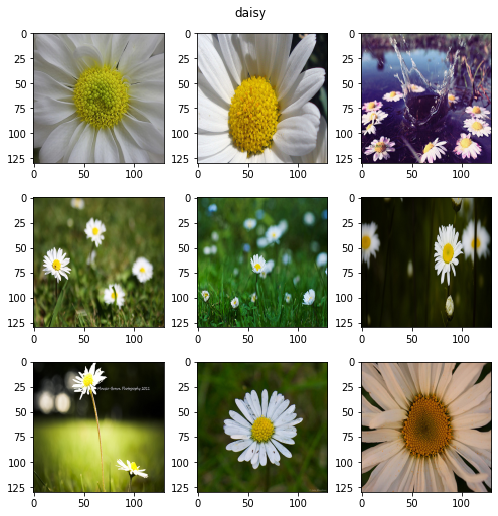

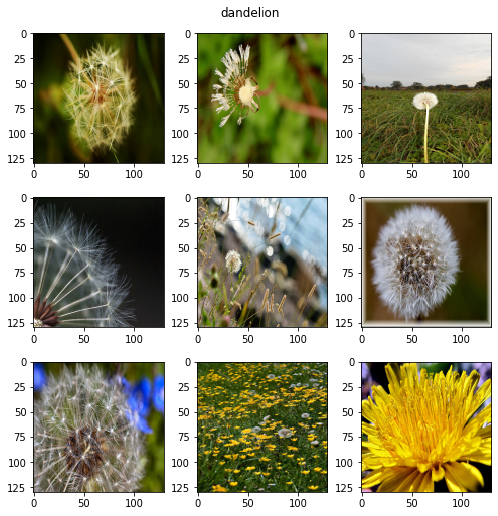

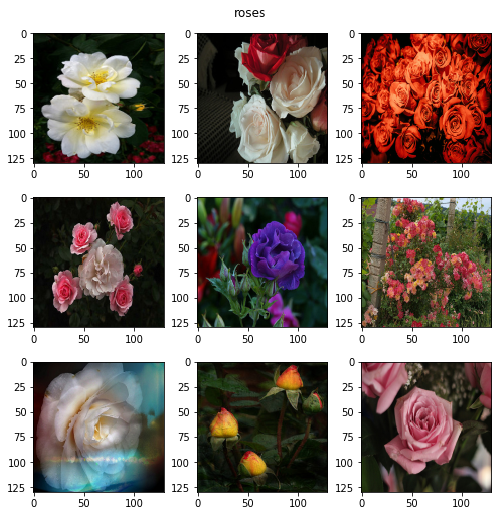

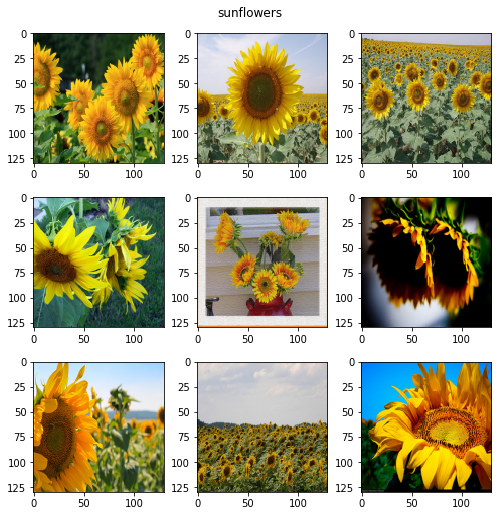

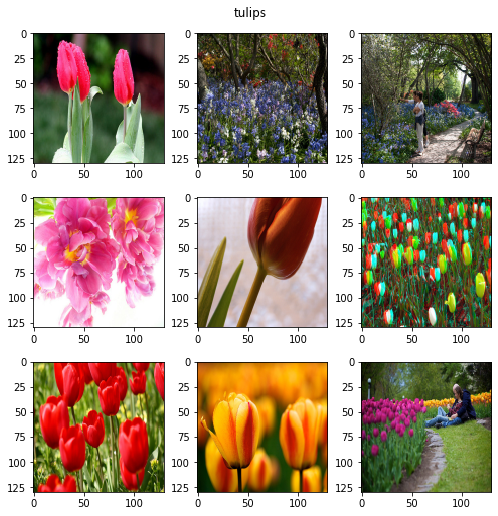

In [7]:
train_x_dat = []; valid_x_dat = []; test_x_dat = []
train_y_dat = []; valid_y_dat = []; test_y_dat = []

for flower_name in flower_list :
#     flower_name = flower_list[0]
    flower_dir = os.path.join(data_dir,flower_name)
    flower_png_list = os.listdir(flower_dir)
    
    # Train
    # cv2는 BRG이기 떄문에 cv2.cvtColor함수로 BRG -> RGB로 변경
    train_x_data_list = np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(flower_dir,s)),cv2.COLOR_BGR2RGB), (130, 130), interpolation = cv2.INTER_AREA) for s in flower_png_list[0:400]])
    train_y_data_list = np.array([flower_name for s in range(train_x_data_list.shape[0])])
    train_x_dat.append(train_x_data_list)
    train_y_dat.append(train_y_data_list)
    
    
    # Valid
    # cv2는 BRG이기 떄문에 cv2.cvtColor함수로 BRG -> RGB로 변경
    valid_x_data_list = np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(flower_dir,s)),cv2.COLOR_BGR2RGB), (130, 130), interpolation = cv2.INTER_AREA) for s in flower_png_list[400:500]])
    valid_y_data_list = np.array([flower_name for s in range(valid_x_data_list.shape[0])])
    valid_x_dat.append(valid_x_data_list)
    valid_y_dat.append(valid_y_data_list)
    
    # Test
    # cv2는 BRG이기 떄문에 cv2.cvtColor함수로 BRG -> RGB로 변경
    test_x_data_list = np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(flower_dir,s)),cv2.COLOR_BGR2RGB), (130, 130), interpolation = cv2.INTER_AREA) for s in flower_png_list[500:600]])
    test_y_data_list = np.array([flower_name for s in range(test_x_data_list.shape[0])])
    test_x_dat.append(test_x_data_list)
    test_y_dat.append(test_y_data_list)
    
    
    # graph
    fig, ax = plt.subplots(3,3, figsize = (7,7))
#     ax = ax.ravel()
    for i in range(3):
        ax[0][i].imshow(train_x_data_list[i])
    for i in range(3):
        ax[1][i].imshow(valid_x_data_list[i])
    for i in range(3):
        ax[2][i].imshow(test_x_data_list[i])
        
    fig.tight_layout()    
    fig.suptitle(flower_name, y = 1.02) 

### 데이터 전처리

In [8]:
train_y_dat = np.array(train_y_dat).flatten()
valid_y_dat = np.array(valid_y_dat).flatten()
test_y_dat = np.array(test_y_dat).flatten()

In [9]:
train_onehot_y = np.array(pd.get_dummies(train_y_dat))
valid_onehot_y = np.array(pd.get_dummies(valid_y_dat))
test_onehot_y = np.array(pd.get_dummies(test_y_dat))

train_array_x = np.array(train_x_dat).reshape(len(train_y_dat),130,130,3)
valid_array_x = np.array(valid_x_dat).reshape(len(valid_y_dat),130,130,3)
test_array_x = np.array(test_x_dat).reshape(len(test_y_dat),130,130,3)

In [10]:
# Scale
train_array_x = train_array_x/255
valid_array_x = valid_array_x/255
test_array_x = test_array_x/255

### Cnn 모델링 - HB vs BO

       Tuning Method : Hyper Band       
Tuner Search Try - 00
INFO:tensorflow:Oracle triggered exit
{'initializer': 'orthogonal', 'Pooling': 'Max', 'num_layers': 2, 'units_1': 128, 'dropout_1': True, 'dense_drop1': 0.4, 'dense1_units': 64, 'dense_drop2': 0.2, 'l2': 0.015899863080462404, 'lr': 0.00031531212959390147, 'conv1_drop': 0.2, 'units_2': 32, 'dropout_2': True, 'conv2_drop': 0.1, 'units_3': 32, 'dropout_3': False, 'conv3_drop': 0.30000000000000004, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 130, 130, 3)]     0         
                                                                 
 cnn_layer_1 (Conv2D)        (None, 130, 130, 128)     3584      
                                                                 
 conv1_nor (BatchNormalizati  (None, 130, 

Epoch 35/100
63/63 [==============================] - 145s 2s/step - loss: 0.2329 - acc: 0.9240 - val_loss: 0.7425 - val_acc: 0.7540 - lr: 2.0180e-04
Epoch 36/100
63/63 [==============================] - 146s 2s/step - loss: 0.2353 - acc: 0.9260 - val_loss: 0.7758 - val_acc: 0.7340 - lr: 2.0180e-04
Epoch 37/100
63/63 [==============================] - 146s 2s/step - loss: 0.2182 - acc: 0.9330 - val_loss: 0.7479 - val_acc: 0.7640 - lr: 2.0180e-04
Epoch 38/100
63/63 [==============================] - 145s 2s/step - loss: 0.2256 - acc: 0.9310 - val_loss: 0.7338 - val_acc: 0.7440 - lr: 2.0180e-04
Epoch 39/100
63/63 [==============================] - 147s 2s/step - loss: 0.2095 - acc: 0.9415 - val_loss: 0.7928 - val_acc: 0.7300 - lr: 1.6144e-04
Epoch 40/100
63/63 [==============================] - 147s 2s/step - loss: 0.2165 - acc: 0.9380 - val_loss: 0.8072 - val_acc: 0.7260 - lr: 1.6144e-04
Epoch 41/100
63/63 [==============================] - 147s 2s/step - loss: 0.1934 - acc: 0.9430 - va

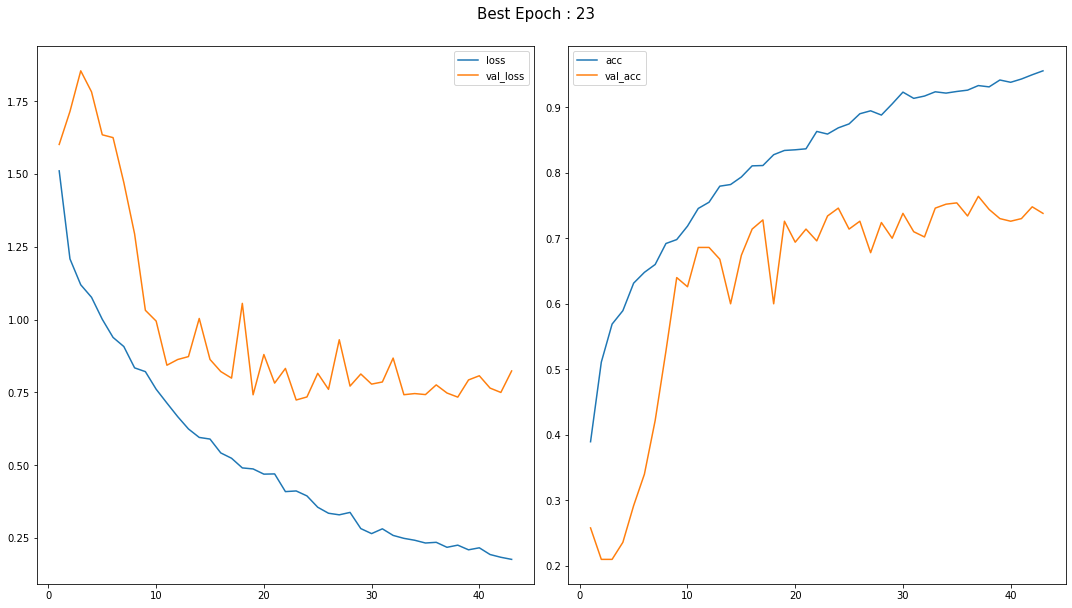

 Tuning Method : Bayesian Optimization  
Tuner Search Try - 00
INFO:tensorflow:Oracle triggered exit
{'initializer': 'random_normal', 'Pooling': 'Avg', 'num_layers': 3, 'units_1': 32, 'dropout_1': True, 'dense_drop1': 0.1, 'dense1_units': 64, 'dense_drop2': 0.5, 'l2': 0.03302634612857312, 'lr': 0.0006644010668800896, 'conv1_drop': 0.1, 'units_2': 128, 'dropout_2': False, 'conv2_drop': 0.30000000000000004, 'units_3': 32, 'dropout_3': True, 'conv3_drop': 0.5}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 130, 130, 3)]     0         
                                                                 
 cnn_layer_1 (Conv2D)        (None, 130, 130, 32)      896       
                                                                 
 conv1_nor (BatchNormalizati  (None, 130, 130, 32)     128       
 on)                                                       

Epoch 30/100
63/63 [==============================] - 48s 765ms/step - loss: 0.5380 - acc: 0.8200 - val_loss: 1.0983 - val_acc: 0.6500 - lr: 5.3152e-04
Epoch 31/100
63/63 [==============================] - 50s 798ms/step - loss: 0.5466 - acc: 0.8270 - val_loss: 0.9067 - val_acc: 0.6680 - lr: 5.3152e-04
Epoch 32/100
63/63 [==============================] - 49s 786ms/step - loss: 0.5243 - acc: 0.8260 - val_loss: 0.6877 - val_acc: 0.7640 - lr: 4.2522e-04
Epoch 33/100
63/63 [==============================] - 50s 788ms/step - loss: 0.4866 - acc: 0.8350 - val_loss: 0.8836 - val_acc: 0.7000 - lr: 4.2522e-04
Epoch 34/100
63/63 [==============================] - 49s 774ms/step - loss: 0.4754 - acc: 0.8470 - val_loss: 0.9681 - val_acc: 0.6660 - lr: 4.2522e-04
Epoch 35/100
63/63 [==============================] - 48s 766ms/step - loss: 0.4718 - acc: 0.8420 - val_loss: 0.8177 - val_acc: 0.7080 - lr: 4.2522e-04
Epoch 36/100
63/63 [==============================] - 48s 766ms/step - loss: 0.4858 - ac

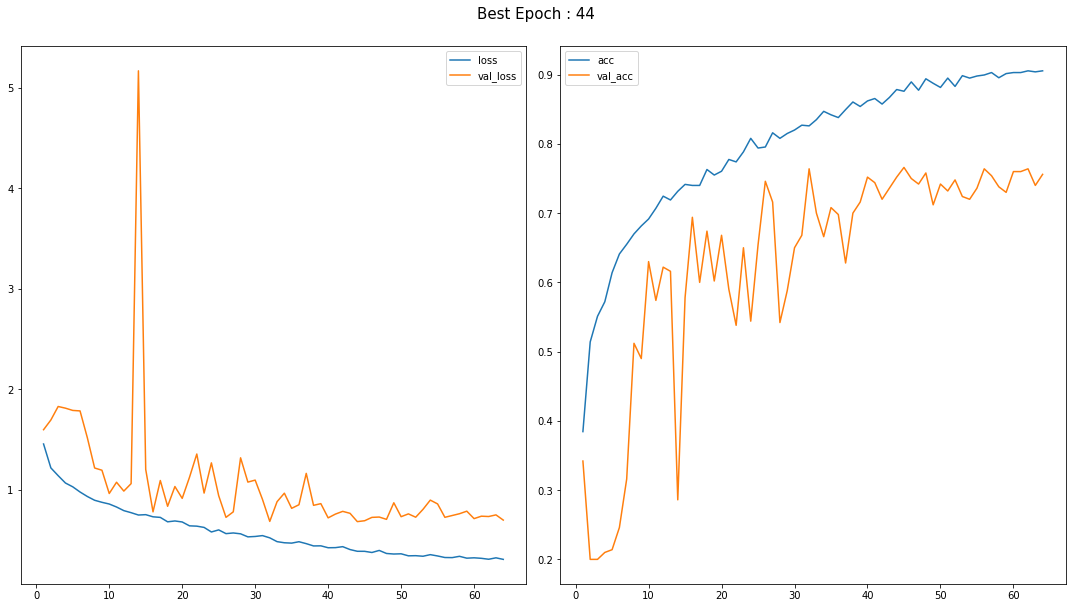

In [11]:
# 모델 저장 경로
hb_mdl_path = os.path.join(model_path,'cnn_model_hb.h5')
bo_mdl_path = os.path.join(model_path,'cnn_model_bo.h5')

# 모델 Fit
cnn_model_hb = mdl.MODELING_CNN(train_array_x,train_onehot_y,valid_array_x, valid_onehot_y, "HB")
cnn_model_bo = mdl.MODELING_CNN(train_array_x,train_onehot_y,valid_array_x, valid_onehot_y, "BO")

# 모델 저장
cnn_model_hb.model.save(hb_mdl_path)
cnn_model_bo.model.save(bo_mdl_path)

### Test Acc 비교

In [19]:
hb_pred = cnn_model_hb.model.evaluate(test_array_x, test_onehot_y)
bo_pred = cnn_model_bo.model.evaluate(test_array_x, test_onehot_y)

16/16 [==============================] - 2s 150ms/step - loss: 0.7473 - acc: 0.7600


### Weight 비교

In [74]:
#hb model
hb_model_layer_weight_list = \
[(cnn_model_hb.model.layers[s].name , cnn_model_hb.model.layers[s].get_weights()[0].flatten()) 
 for s in range(len(cnn_model_hb.model.layers)) 
 if len(cnn_model_hb.model.layers[s].get_weights()) > 0]

#bo model
bo_model_layer_weight_list = \
[(cnn_model_bo.model.layers[s].name , cnn_model_bo.model.layers[s].get_weights()[0].flatten()) 
 for s in range(len(cnn_model_bo.model.layers)) 
 if len(cnn_model_bo.model.layers[s].get_weights()) > 0]

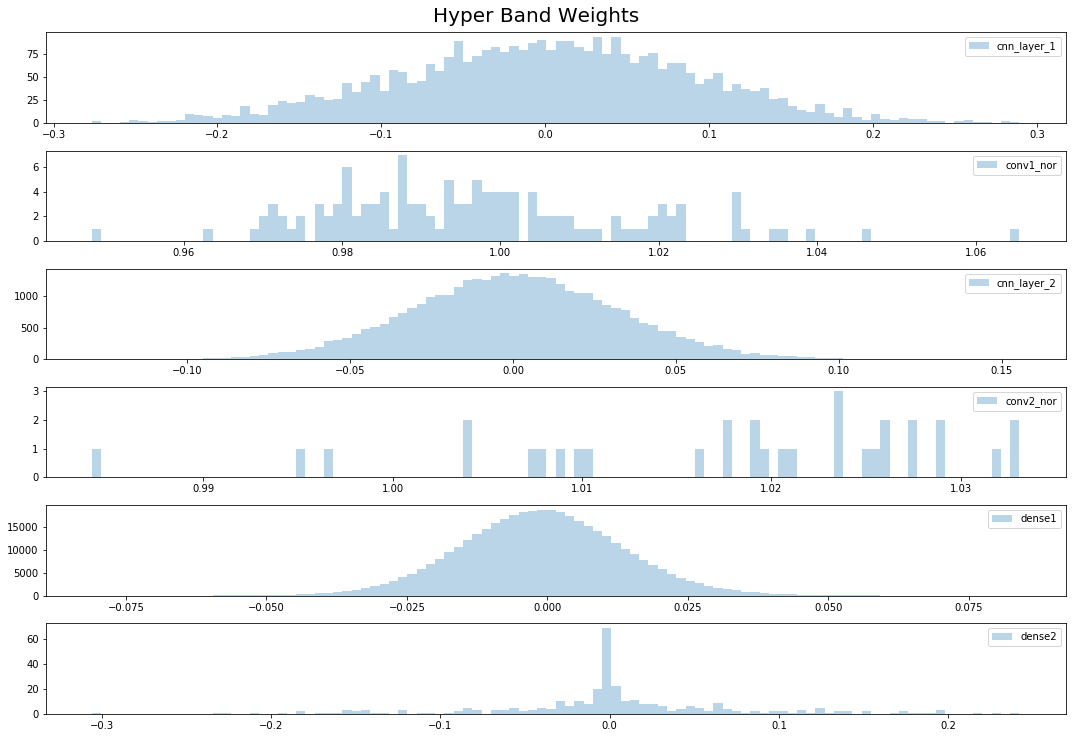

In [104]:
# Hyper Band Model Weight Plot
_len = len(hb_model_layer_weight_list)
fig, ax = plt.subplots(_len,1,figsize = (15,10))
ax = ax.flatten()

for idx in range(_len):
    ax[idx].hist(hb_model_layer_weight_list[idx][1], alpha = 0.3, label = hb_model_layer_weight_list[idx][0], bins = 100)
    ax[idx].legend()
fig.suptitle('Hyper Band Weights', y = 1.02, fontsize = 20)
fig.tight_layout()

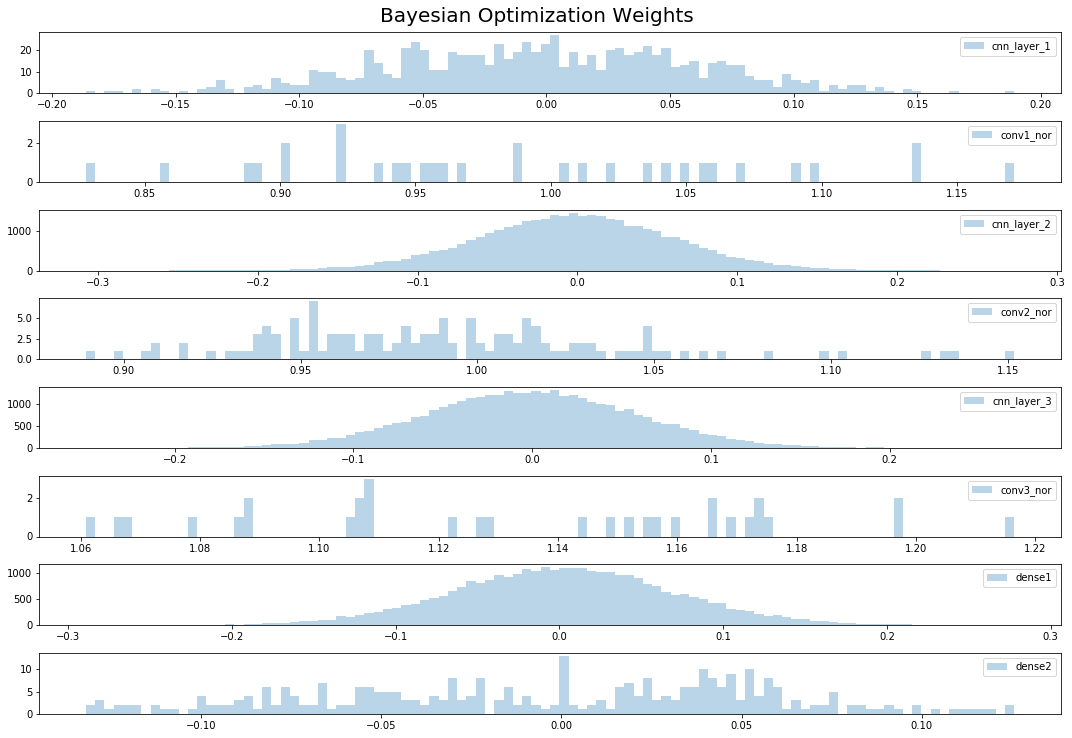

In [106]:
# Bayesian Optimization Model Weight Plot
_len = len(bo_model_layer_weight_list)
fig, ax = plt.subplots(_len,1,figsize = (15,10))
ax = ax.flatten()

for idx in range(_len):
    ax[idx].hist(bo_model_layer_weight_list[idx][1], alpha = 0.3, label = bo_model_layer_weight_list[idx][0], bins = 100)
    ax[idx].legend()
fig.suptitle('Bayesian Optimization Weights', y = 1.02, fontsize = 20)
fig.tight_layout()

### Feature Map

#### Hyper Band Model Feature Map

In [291]:
hb_feature_map_layer_list = \
[(cnn_model_hb.model.layers[s].name,cnn_model_hb.model.layers[s]) 
 for s in range(len(cnn_model_hb.model.layers)) 
 if len(cnn_model_hb.model.layers[s].get_weights()) > 0]

feature_map_model_hb = tf.keras.Model(inputs = cnn_model_hb.model.layers[0].input, 
                                      outputs = [hb_feature_map_layer_list[s][1].output for s in range(len(hb_feature_map_layer_list))
                                                if 'dense' not in hb_feature_map_layer_list[s][0]])

1/1 [==============================] - 0s 66ms/step


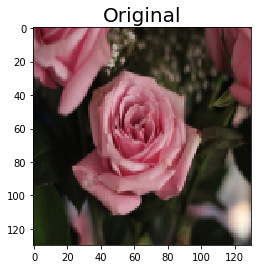

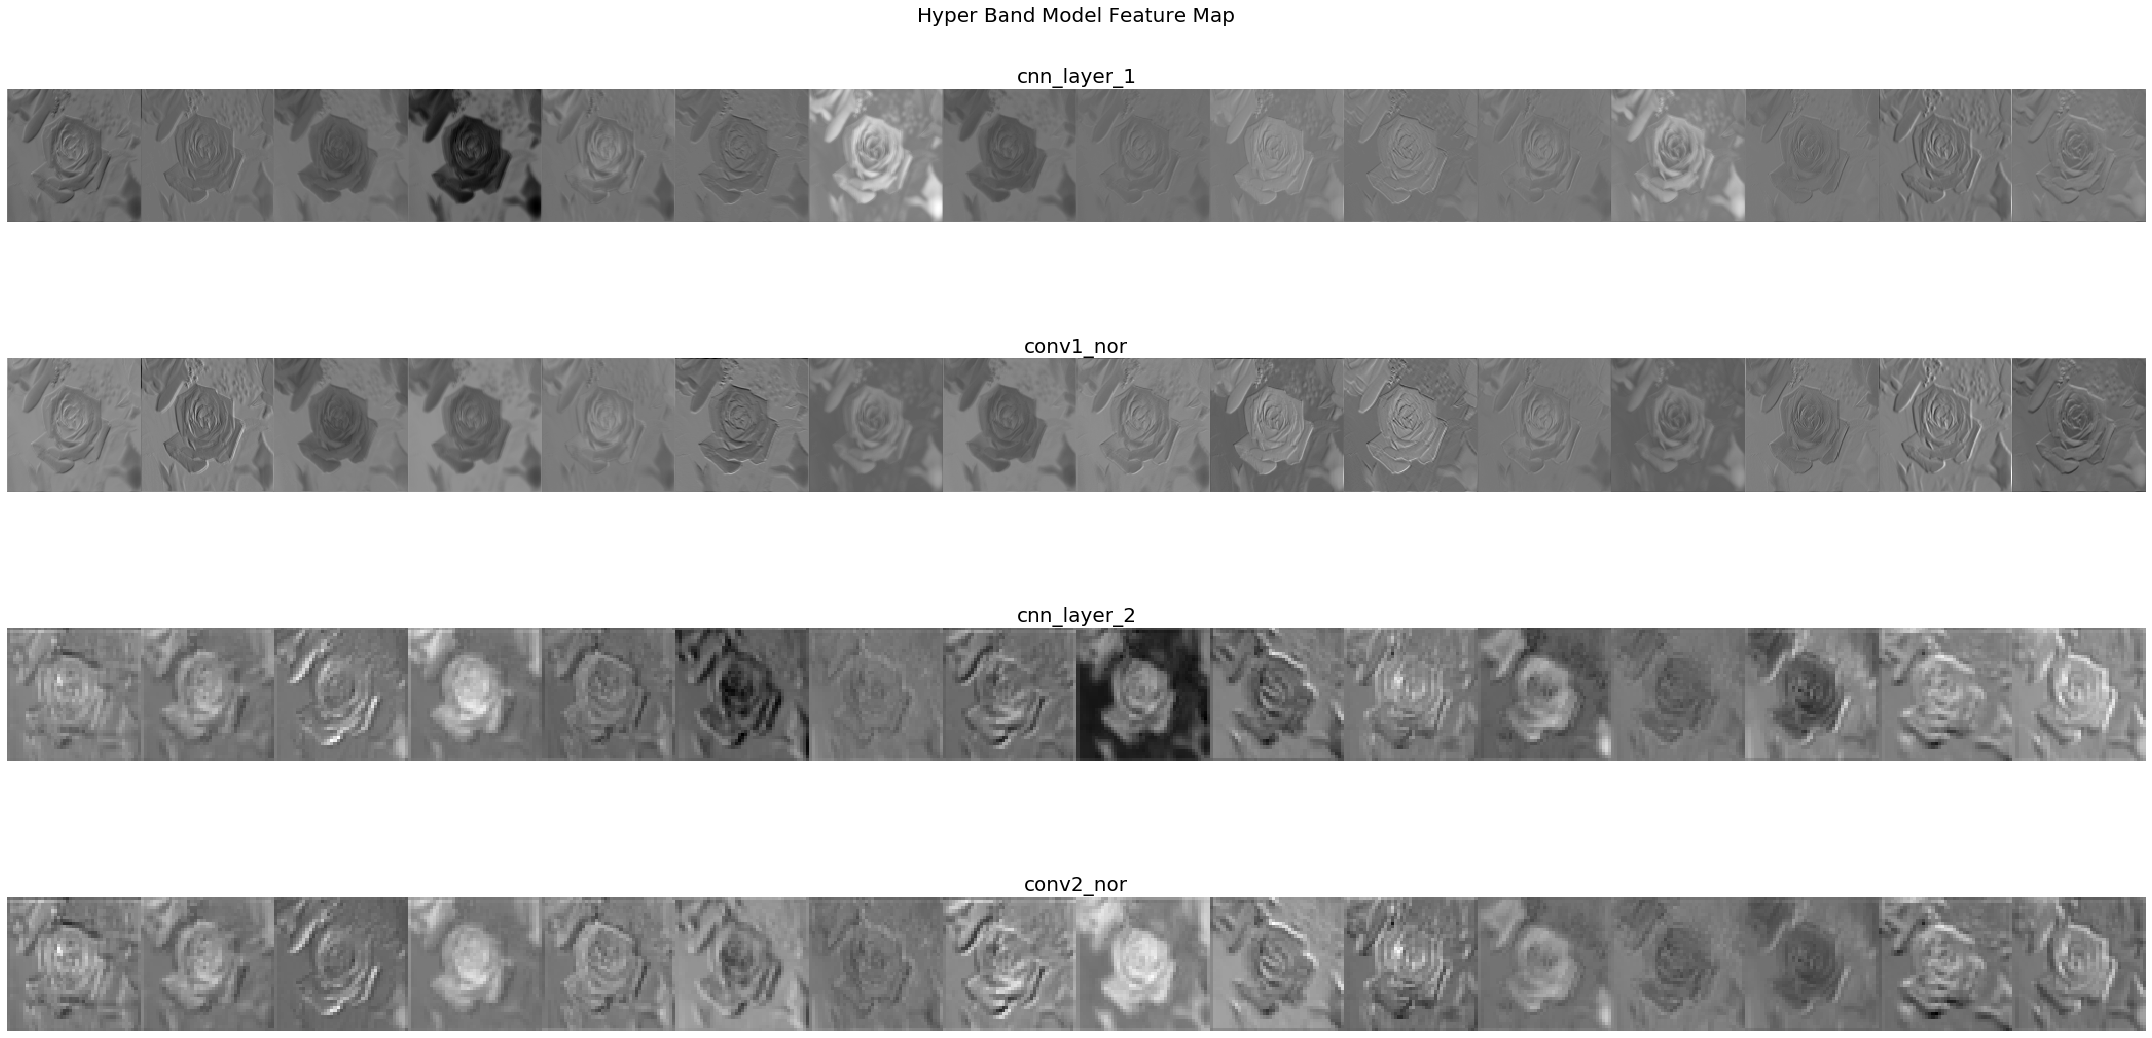

In [330]:
# Feature Map을 그릴 샘플 선택
sam_idx = 202
hb_feature_map = feature_map_model_hb.predict(test_array_x[sam_idx:(sam_idx+1),:,:,:])

# original image
fig = plt.figure(figsize = (4,4))
plt.imshow(test_array_x[sam_idx,:,:,:])
plt.title('Original', fontsize = 20)

# Graph
fig, ax = plt.subplots(len(hb_feature_map),1,figsize = (30,4*len(hb_feature_map)))
ax = ax.flatten()
for layer_n in range(len(hb_feature_map)):
    length  = np.squeeze(hb_feature_map[layer_n]).shape[0]
    width   = np.squeeze(hb_feature_map[layer_n]).shape[1]
    channel = np.squeeze(hb_feature_map[layer_n]).shape[2]
    feature_map_belt = np.zeros(length * width * channel).reshape(length, width * channel)
    
    for idx in range(channel):
        feature_map_belt[:,(idx * width):(idx+1) * width] = np.squeeze(hb_feature_map[layer_n])[:,:,idx]
                                                                                                
    n_show_filter = min(16,hb_feature_map[layer_n].shape[-1])
    ax[layer_n].imshow(feature_map_belt[:,0:(n_show_filter*width)], cmap='gray')    
    ax[layer_n].set_title(feature_map_model_hb.outputs[layer_n].name.split('/')[0], fontsize = 20)
    ax[layer_n].axis('off')
fig.suptitle("Hyper Band Model Feature Map", fontsize = 20)
fig.tight_layout()

#### Bayesian Optimization Model

In [297]:
bo_feature_map_layer_list = \
[(cnn_model_bo.model.layers[s].name,cnn_model_bo.model.layers[s]) 
 for s in range(len(cnn_model_bo.model.layers)) 
 if len(cnn_model_bo.model.layers[s].get_weights()) > 0]

feature_map_model_bo = tf.keras.Model(inputs = cnn_model_bo.model.layers[0].input, 
                                      outputs = [bo_feature_map_layer_list[s][1].output for s in range(len(bo_feature_map_layer_list))
                                                if 'dense' not in bo_feature_map_layer_list[s][0]])

1/1 [==============================] - 0s 21ms/step


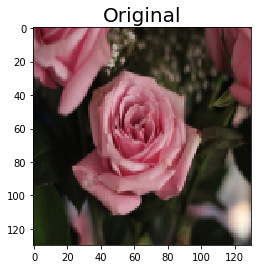

In [ ]:
# Feature Map을 그릴 샘플 선택
sam_idx = 202
bo_feature_map = feature_map_model_bo.predict(test_array_x[sam_idx:(sam_idx+1),:,:,:])

# original image
fig = plt.figure(figsize = (4,4))
plt.imshow(test_array_x[sam_idx,:,:,:])
plt.title('Original', fontsize = 20)

# Graph
fig, ax = plt.subplots(len(bo_feature_map),1,figsize = (30,4*len(bo_feature_map)))
ax = ax.flatten()
for layer_n in range(len(bo_feature_map)):
    length  = np.squeeze(bo_feature_map[layer_n]).shape[0]
    width   = np.squeeze(bo_feature_map[layer_n]).shape[1]
    channel = np.squeeze(bo_feature_map[layer_n]).shape[2]
    feature_map_belt = np.zeros(length * width * channel).reshape(length, width * channel)
    
    for idx in range(channel):
        feature_map_belt[:,(idx * width):(idx+1) * width] = np.squeeze(bo_feature_map[layer_n])[:,:,idx]
                                                                                                
    n_show_filter = min(16,bo_feature_map[layer_n].shape[-1])
    ax[layer_n].imshow(feature_map_belt[:,0:(n_show_filter*width)], cmap='gray')    
    ax[layer_n].set_title(feature_map_model_bo.outputs[layer_n].name.split('/')[0], fontsize = 20)
    ax[layer_n].axis('off')  
fig.suptitle("Bayesian Optimization Feature Map", fontsize = 20)
fig.tight_layout()